In [198]:
import matplotlib.pyplot as plt
import seaborn as sns

In [199]:
import pandas as pd

In [200]:
customers_file = "/content/drive/MyDrive/Zeotap/Customers.csv"
products_file = "/content/drive/MyDrive/Zeotap/Products.csv"
transactions_file = "/content/drive/MyDrive/Zeotap/Transactions.csv"

In [201]:
customers_df = pd.read_csv(customers_file)
products_df = pd.read_csv(products_file)
transactions_df = pd.read_csv(transactions_file)

In [202]:
customers_df.head()

,CustomerID,CustomerName,Region,SignupDate
0,C0001,Lawrence Carroll,South America,2022-07-10
1,C0002,Elizabeth Lutz,Asia,2022-02-13
2,C0003,Michael Rivera,South America,2024-03-07
3,C0004,Kathleen Rodriguez,South America,2022-10-09
4,C0005,Laura Weber,Asia,2022-08-15


In [203]:
products_df.head()

,ProductID,ProductName,Category,Price
0,P001,ActiveWear Biography,Books,169.30
1,P002,ActiveWear Smartwatch,Electronics,346.30
2,P003,ComfortLiving Biography,Books,44.12
3,P004,BookWorld Rug,Home Decor,95.69
4,P005,TechPro T-Shirt,Clothing,429.31


In [204]:
transactions_df.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68


In [205]:
merged_df = pd.merge(transactions_df, customers_df, on="CustomerID", how="inner")

In [206]:
merged_df.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,CustomerName,Region,SignupDate
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Travis Campbell,South America,2024-04-11
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,Europe,2022-03-15


In [207]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TransactionID    1000 non-null   object 
 1   CustomerID       1000 non-null   object 
 2   ProductID        1000 non-null   object 
 3   TransactionDate  1000 non-null   object 
 4   Quantity         1000 non-null   int64  
 5   TotalValue       1000 non-null   float64
 6   Price            1000 non-null   float64
 7   CustomerName     1000 non-null   object 
 8   Region           1000 non-null   object 
 9   SignupDate       1000 non-null   object 
dtypes: float64(2), int64(1), object(7)
memory usage: 78.3+ KB


In [208]:
merged_df.describe()

,Quantity,TotalValue,Price
count,1000.000000,1000.000000,1000.00000
mean,2.537000,689.995560,272.55407
std,1.117981,493.144478,140.73639
min,1.000000,16.080000,16.08000
25%,2.000000,295.295000,147.95000
50%,3.000000,588.880000,299.93000
75%,4.000000,1011.660000,404.40000
max,4.000000,1991.040000,497.76000


In [209]:
merged_df["TransactionDate"] = pd.to_datetime(merged_df["TransactionDate"])
merged_df["SignupDate"] = pd.to_datetime(merged_df["SignupDate"])

In [210]:
customer_features = merged_df.groupby("CustomerID").agg(
    total_transactions=("TransactionID", "count"),
    total_quantity=("Quantity", "sum"),
    total_spent=("TotalValue", "sum"),
    avg_transaction_value=("TotalValue", "mean"),
    days_since_signup=(
        "SignupDate",
        lambda x: (pd.Timestamp("2025-01-27") - x.max()).days,
    ),
    region=("Region", "first"),
).reset_index()

In [211]:
customer_features = pd.get_dummies(customer_features, columns=["region"], drop_first=True)
customer_features.head()

,CustomerID,total_transactions,total_quantity,total_spent,avg_transaction_value,days_since_signup,region_Europe,region_North America,region_South America
0,C0001,5,12,3354.52,670.904,932,False,False,True
1,C0002,4,10,1862.74,465.685,1079,False,False,False
2,C0003,4,14,2725.38,681.345,326,False,False,True
3,C0004,8,23,5354.88,669.360,841,False,False,True
4,C0005,3,7,2034.24,678.080,896,False,False,False


In [212]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [213]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(
    customer_features.drop(columns=["CustomerID"])
)

In [214]:
db_indices = []
silhouette_scores = []
clusters_range = range(2, 11)

Elbow Method to find optimal K

In [215]:
for k in clusters_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = kmeans.fit_predict(scaled_features)
    db_index = davies_bouldin_score(scaled_features, labels)
    silhouette_avg = silhouette_score(scaled_features, labels)
    db_indices.append(db_index)
    silhouette_scores.append(silhouette_avg)

In [216]:
optimal_k = clusters_range[np.argmin(db_indices)]

In [217]:
optimal_k

5

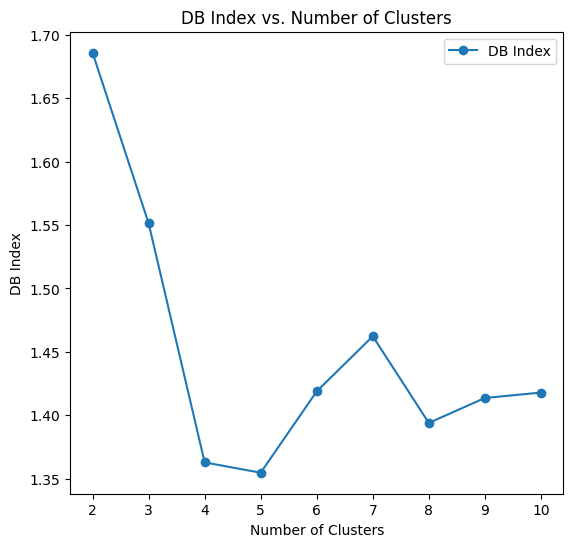

In [218]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(clusters_range, db_indices, marker="o", label="DB Index")
plt.title("DB Index vs. Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("DB Index")
plt.legend()


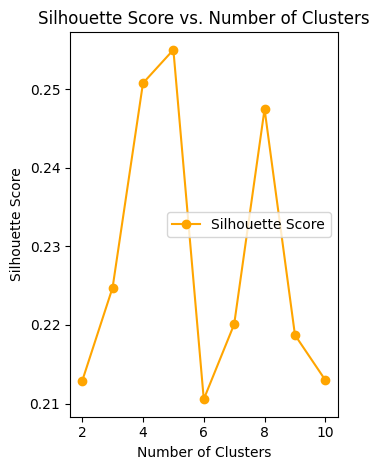

In [219]:
plt.subplot(1, 2, 2)
plt.plot(clusters_range, silhouette_scores, marker="o", label="Silhouette Score", color="orange")
plt.title("Silhouette Score vs. Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.legend()
plt.tight_layout()
plt.show()

In [220]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [221]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init="auto") # Changed {optimal_k} to optimal_k
labels = kmeans.fit_predict(scaled_features)
db_index = davies_bouldin_score(scaled_features, labels)
silhouette_avg = silhouette_score(scaled_features, labels)

In [222]:
print(f"DB Index for {optimal_k} Clusters: {db_index}")
print(f"Silhouette Score for {optimal_k} Clusters: {silhouette_avg}")

DB Index for 5 Clusters: 1.3547088760955934
Silhouette Score for 5 Clusters: 0.2549935635490153


In [223]:
scaled_features_df = pd.DataFrame(scaled_features, columns=customer_features.drop(columns=["CustomerID"]).columns)
scaled_features_df["labels"] = labels

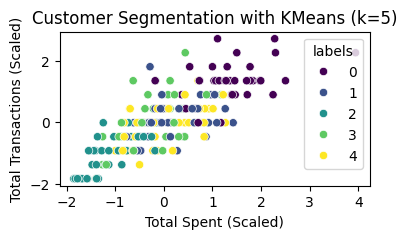

In [224]:
plt.figure(figsize=(4,2))
sns.scatterplot(x='total_spent', y='total_transactions', hue='labels', data=scaled_features_df, palette='viridis')
plt.title(f'Customer Segmentation with KMeans (k={optimal_k})')
plt.xlabel('Total Spent (Scaled)')
plt.ylabel('Total Transactions (Scaled)')
plt.show()